In [1]:
#LIMPIEZA Y MANIPULACION DE DATOS
import pandas as pd
import re
from unidecode import unidecode
import numpy as np
import datetime

#FUNCIONES
from funciones_usisa_sistema_recomendacion import *

#VISUALIZACION
import seaborn as sns
import matplotlib.pyplot as plt

#MODELO
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split

# LIMPIEZA Y MANIPULACIÓN DE DATOS


#### CARGAR Y EDITAR DATA NUEVO

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
df_nuevo = pd.read_csv("tienda_online_nuevo.csv")

In [4]:
df_nuevo = todas_funciones_nuevo(df_nuevo)

# EDA

In [5]:
ventas_por_producto = agrupar_y_seleccionar_nombre(df_nuevo, 'producto_id', 'producto_nombre', 'product_cantidad')

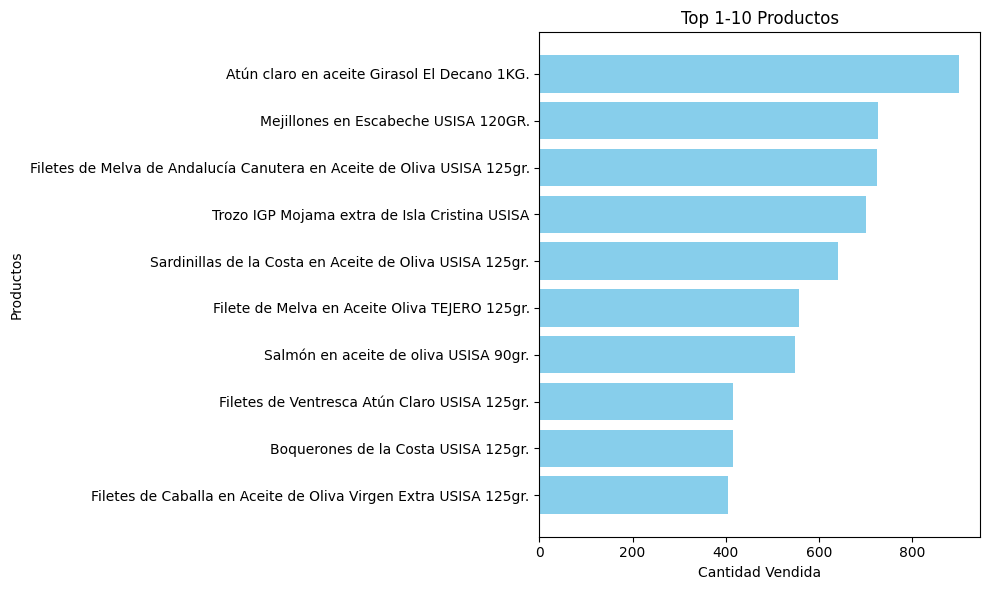

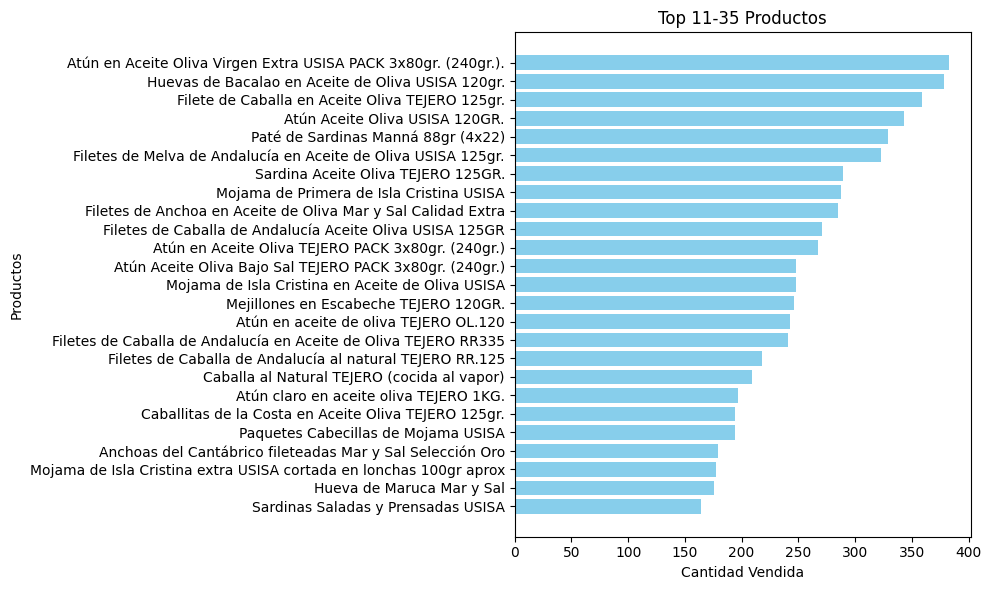

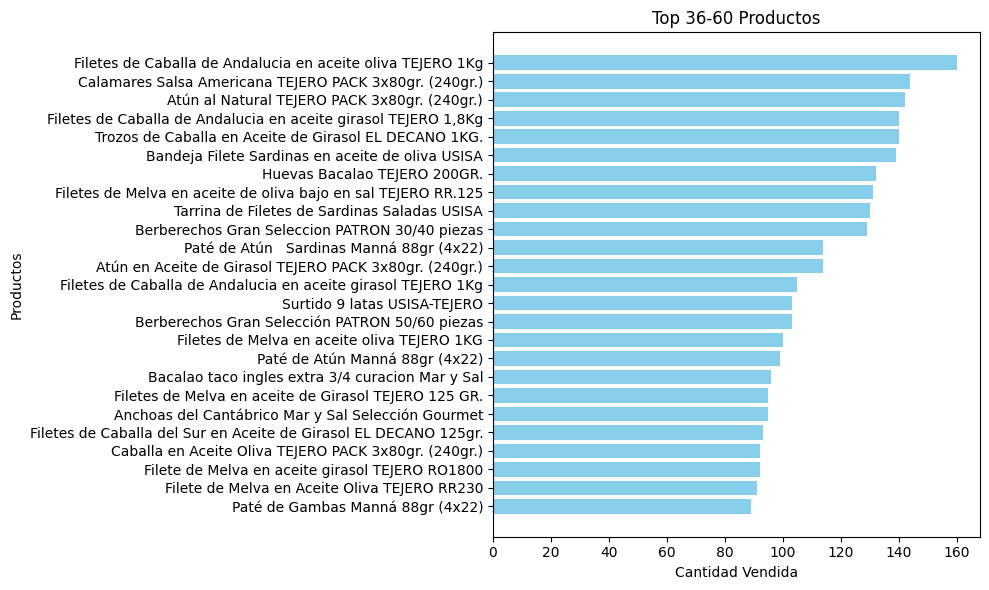

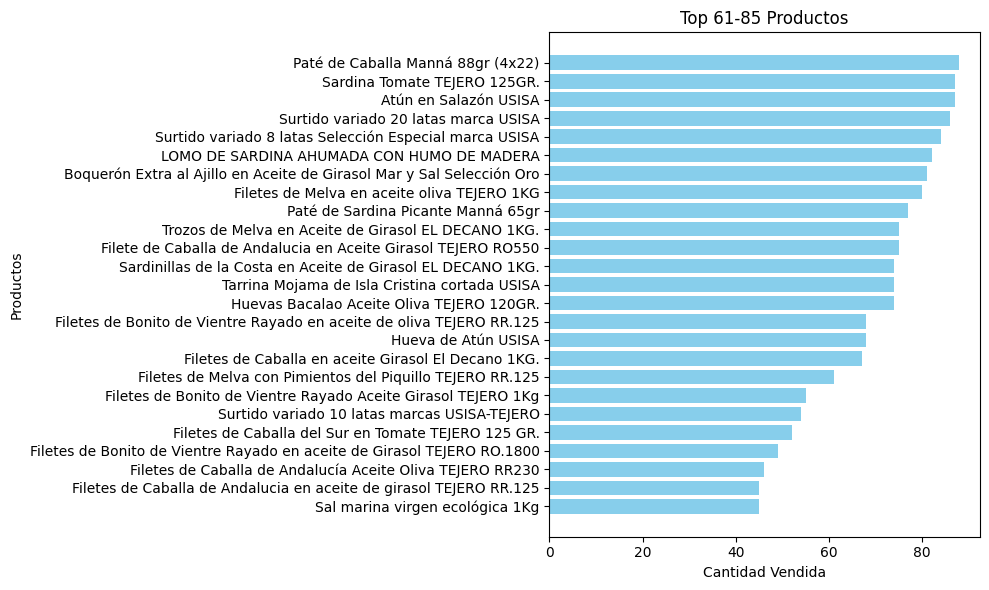

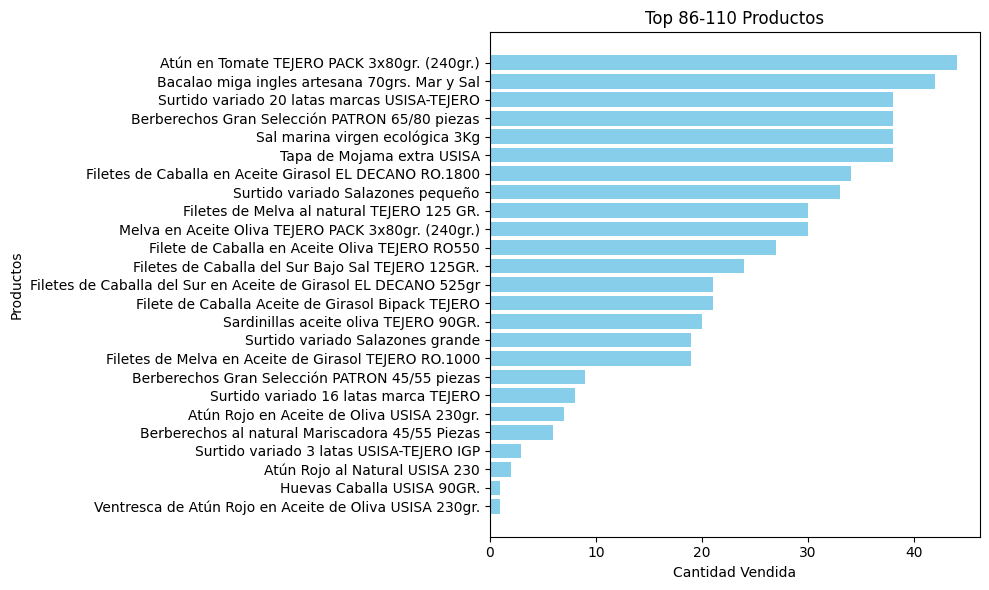

In [6]:
plot_top_segments(ventas_por_producto)

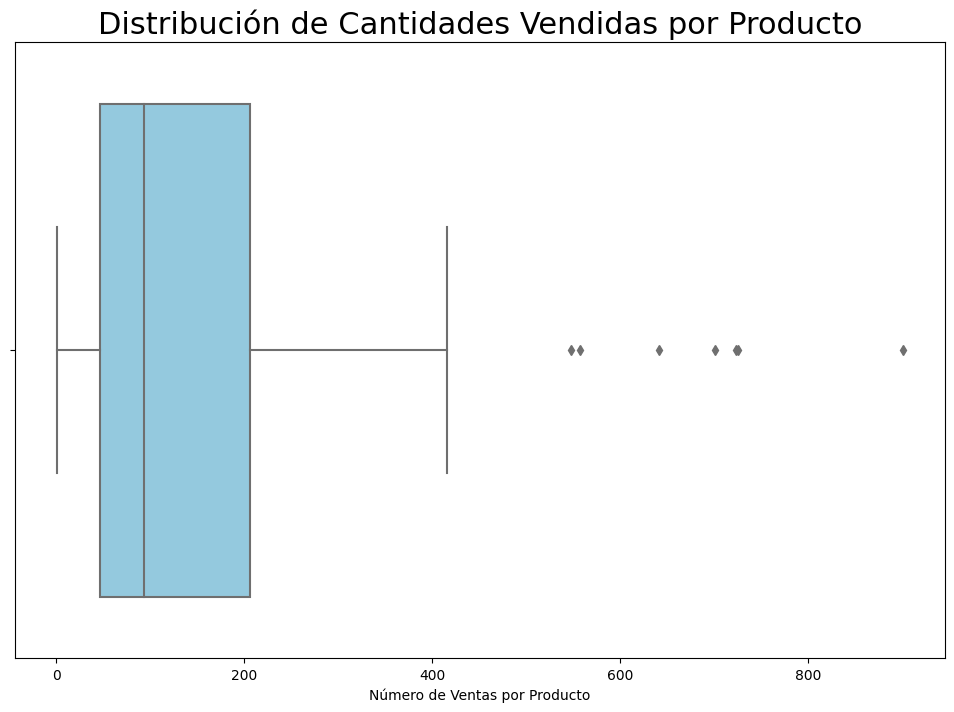

In [7]:
plot_boxplot(ventas_por_producto)

# MODELO DE RECOMENDACIÓN


#### PREPROCESAMIENTO 

In [8]:
df_nuevo['producto_id'] = df_nuevo['producto_id'].astype(str)

In [9]:
basket = df_nuevo.groupby('order_id')['producto_id'].apply(list).reset_index()
te = TransactionEncoder()
basket_encoded = te.fit_transform(basket['producto_id'])
basket_df = pd.DataFrame(basket_encoded, columns=te.columns_)

#### TRAIN/TEST SPLIT

In [10]:
train_basket, test_basket = train_test_split(basket_df, test_size=0.001, random_state=42)

#### ALGORTIMO APRIORI

In [11]:
frequent_itemsets = apriori(train_basket, min_support=0.005, use_colnames=True)

#### REGLAS DE ASOCIACIÓN

In [12]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

#### OBTENER PRODUCTOS RECOMENDADOS DEL TEST

In [13]:
id_nombre_dict = dict(zip(df_nuevo['producto_id'], df_nuevo['producto_nombre']))

In [14]:
def obtener_productos_recomendados(nuevo_pedido):
    productos_recomendados = set()
    for _, row in rules.iterrows():
        if any(item in nuevo_pedido for item in row['antecedents']) and row['consequents']:
            productos_recomendados.update(row['consequents'])
    productos_recomendados -= set(nuevo_pedido)
    return productos_recomendados

In [15]:
test_recommendations = {}
for index, row in test_basket.iterrows():
    nuevo_pedido_test = test_basket.columns[test_basket.loc[index] == 1].tolist()
    productos_recomendados_test = obtener_productos_recomendados(nuevo_pedido_test)
    productos_recomendados_dict_test = {producto_id: id_nombre_dict.get(producto_id, producto_id) for producto_id in productos_recomendados_test}
    test_recommendations[index] = productos_recomendados_dict_test

In [16]:
for order_id, recommendations in test_recommendations.items():
    original_order_id = basket.loc[basket.index == order_id, 'order_id'].values[0]

    # Obtener los productos comprados en el pedido
    productos_comprados = df_nuevo[df_nuevo['order_id'] == original_order_id][['producto_id', 'producto_nombre']]
    
    productos_comprados_dict = dict(zip(productos_comprados['producto_id'], productos_comprados['producto_nombre']))
    
    print(f"Productos comprados en el pedido {original_order_id}: {productos_comprados_dict}")
    
    print(f"Productos recomendados para el pedido {original_order_id}: {recommendations}")

Productos comprados en el pedido 9596: {'1833': 'Atún claro en aceite Girasol El Decano 1KG.', '1895': 'Anchoas del Cantábrico fileteadas Mar y Sal Selección Oro', '2170': 'Boquerón Extra al Ajillo en Aceite de Girasol Mar y Sal Selección Oro'}
Productos recomendados para el pedido 9596: {'2158': 'Mejillones en Escabeche USISA 120GR.'}
Productos comprados en el pedido 7321: {'2156': 'Surtido variado Salazones grande', '1938': 'Surtido variado 8 latas Selección Especial marca USISA', '0': 'Atún Aceite Oliva USISA 120GR.', '1890': 'Anchoas del Cantábrico Mar y Sal Selección Gourmet', '2161': 'Filetes de Melva de Andalucía Canutera en Aceite de Oliva USISA 125gr.', '2158': 'Mejillones en Escabeche USISA 120GR.', '2163': 'Filetes de Ventresca Atún Claro USISA 125gr.'}
Productos recomendados para el pedido 7321: {'1649': 'Atún en Aceite Oliva Virgen Extra USISA PACK 3x80gr. (240gr.).', '1669': 'Sardinillas de la Costa en Aceite de Oliva USISA 125gr.'}


#### OBTENER PRODUCTOS RECOMENDADOS PARA UN NUEVO PEDIDO

In [17]:
nuevo_pedido = ['1580', '2158']  # Coloca los productos del nuevo pedido

In [18]:
def obtener_productos_recomendados(nuevo_pedido):
    carrito = set(nuevo_pedido)  
    productos_recomendados = set()
    for _, row in rules.iterrows():
        if any(item in carrito for item in row['antecedents']) and row['consequents']:
            productos_recomendados.update(row['consequents'])
    productos_recomendados -= carrito
    return productos_recomendados

In [19]:
productos_recomendados = obtener_productos_recomendados(nuevo_pedido)

In [20]:
productos_recomendados_dict = {producto_id: id_nombre_dict.get(producto_id, producto_id) for producto_id in productos_recomendados}

In [21]:
print("Productos comprados en el nuevo pedido:", {producto_id: id_nombre_dict.get(producto_id, producto_id) for producto_id in nuevo_pedido})
print("Productos recomendados para el nuevo pedido:", productos_recomendados_dict)

Productos comprados en el nuevo pedido: {'1580': 'Trozo IGP Mojama extra de Isla Cristina USISA', '2158': 'Mejillones en Escabeche USISA 120GR.'}
Productos recomendados para el nuevo pedido: {'2115': 'Paté de Sardinas Manná 88gr (4x22)', '1669': 'Sardinillas de la Costa en Aceite de Oliva USISA 125gr.', '2154': 'Paté de Gambas Manná 88gr (4x22)'}


#### CONFIANZA DEL MODELO DE RECOMENDACIÓN

In [22]:
rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))
confidence = rules['confidence']

for i in range(len(rules)):
    print(f"Regla {i + 1}:")
    print(f"Confianza: {confidence[i]}")
    print("="*20)

Regla 1:
Confianza: 0.6923076923076924
Regla 2:
Confianza: 0.6923076923076924
Regla 3:
Confianza: 0.8
Regla 4:
Confianza: 0.6000000000000001
Regla 5:
Confianza: 0.6
Regla 6:
Confianza: 0.6666666666666667
Regla 7:
Confianza: 0.6000000000000001
Regla 8:
Confianza: 0.6428571428571429
Regla 9:
Confianza: 0.6000000000000001
Regla 10:
Confianza: 0.6875
Regla 11:
Confianza: 0.6470588235294117
Regla 12:
Confianza: 0.6470588235294117
Regla 13:
Confianza: 0.75
Regla 14:
Confianza: 0.6428571428571429
Regla 15:
Confianza: 0.6000000000000001
Regla 16:
Confianza: 0.6000000000000001
Regla 17:
Confianza: 0.6000000000000001
Regla 18:
Confianza: 0.6875
Regla 19:
Confianza: 0.611111111111111
Regla 20:
Confianza: 0.611111111111111
Regla 21:
Confianza: 0.6000000000000001
